In [1]:
"""
Created on Wed Jan 10 17:13:16 2024
@author: Wu Yuxuan
"""

import os
import warnings

import scFates as scf
import pandas as pd
import anndata as ad
import scanpy as sc
import seaborn as sns
import numpy as np
from matplotlib import rc_context
from matplotlib import pyplot as plt
from ridgeplot import ridgeplot

import cellrank as cr
# import scanpy as sc
import scvelo as scv

from statannotations.Annotator import Annotator

In [2]:
seed = 1
warnings.simplefilter(action='ignore', category=FutureWarning)
# info
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.set_figure_params(vector_friendly=True, dpi_save=1200) 
sc.logging.print_header()

scanpy==0.1.dev3254+g5b9bc72 anndata==0.10.3 umap==0.5.5 numpy==1.26.0 scipy==1.11.3 pandas==1.5.2 scikit-learn==1.1.3 statsmodels==0.14.0 igraph==0.10.8 louvain==0.8.1 pynndescent==0.5.11


In [3]:
os.chdir('/home/wu/datb1/reseq_ppp/Pub_PPP_code')

In [4]:
sns.set_style("white")

In [5]:
adata_ker = ad.read_h5ad('/home/wu/datb1/reseq_ppp/processed_data/KC_PPP_10X.h5ad')

In [6]:
adata_ker.obs['batch_group'] = adata_ker.obs.batch_group.cat.reorder_categories(['HC', 'NL', 'Lesion'])
adata_ker.uns['batch_group_colors'] = ['#3182bd', '#31a354', '#fd8d3c']

df_name = adata_ker.obs['batch'].astype(str).str.split("_", expand=True)
df_name.loc[df_name.index.str.contains('PPP'), 1] = df_name.loc[df_name.index.str.contains('PPP'), 1].str.split("C", expand=True)[0]
df_name = df_name[0] + '_' + df_name[1]
# df_name.str.split("C", expand=True)[0]
# df_name[df_name.index.str.contains('PPP_')] = df_name[df_name.index.str.contains('PPP')].str.split("C", expand=True)[0]
adata_ker.obs['patient'] = df_name.copy()
adata_ker.obs['patient'].value_counts()

HC_HC02     5708
PPPC_P38    5033
PPPC_P37    4132
PPPC_P39    3103
PPP_P18     2540
PPP_P36     1224
PPP_P24     1046
PPP_P40     1012
PPP_P37      944
PPP_P38      856
PPP_P39      401
HC_HC01      148
PPP_P17      139
PPP_P16       50
Name: patient, dtype: int64

### Phase fraction

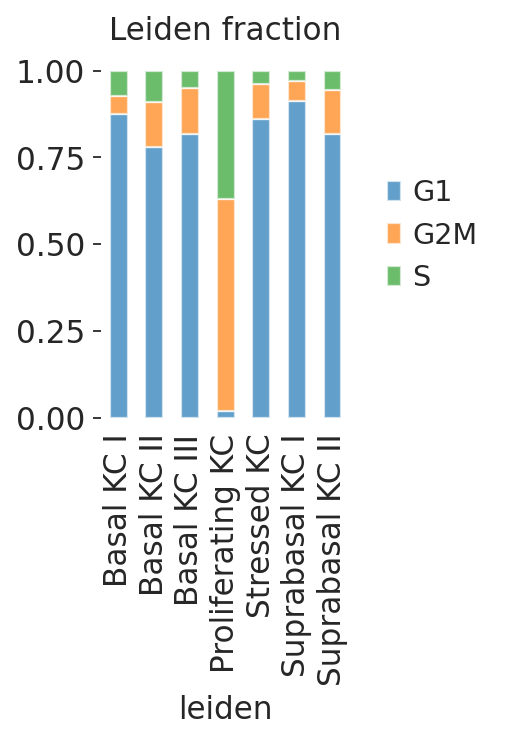

In [7]:
with rc_context({'figure.figsize': (2, 3)}):
    ax = (adata_ker.obs.groupby(['leiden', 'phase']).size() / adata_ker.obs.groupby('leiden').size()).unstack() \
            .plot.bar(stacked=True, color=sns.color_palette("tab10"), width=0.5, alpha=0.7)
    ax.legend(bbox_to_anchor=(1.1, 0.5), loc='center left', borderaxespad=0., frameon=False)
    sns.despine(left=True, bottom=True)
    plt.title("Leiden fraction")
    plt.tick_params(top=False,bottom=False,left=True,right=False)
    plt.savefig('figures/fig2_2/leiden_phase_fraction.pdf', bbox_inches='tight')

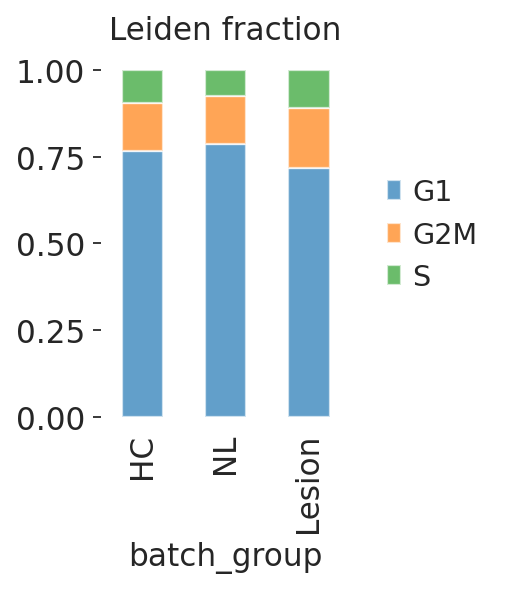

In [8]:
with rc_context({'figure.figsize': (2, 3)}):
    ax = (adata_ker.obs.groupby(['batch_group', 'phase']).size() / adata_ker.obs.groupby('batch_group').size()).unstack() \
            .plot.bar(stacked=True, color=sns.color_palette("tab10"), width=0.5, alpha=0.7)
    ax.legend(bbox_to_anchor=(1.1, 0.5), loc='center left', borderaxespad=0., frameon=False)
    sns.despine(left=True, bottom=True)
    plt.title("Leiden fraction")
    plt.tick_params(top=False,bottom=False,left=True,right=False)
    plt.savefig('figures/fig2_2/batch_group_phase_fraction.pdf', bbox_inches='tight')

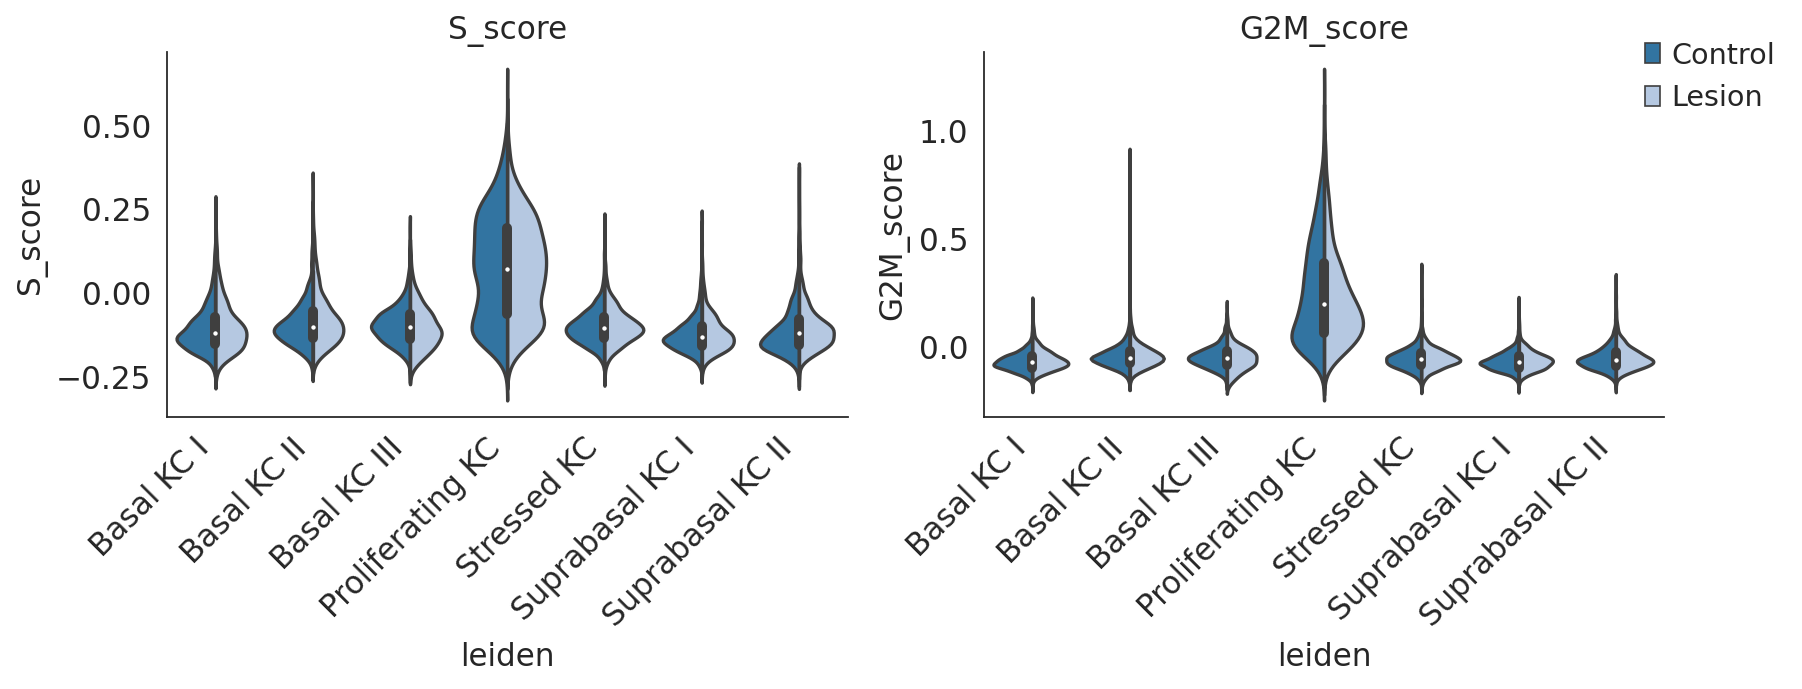

In [9]:
with rc_context({'figure.figsize': (12, 3)}):
    fig, ax = plt.subplots(ncols=2)
    sns.violinplot(x='leiden', y='S_score', data=adata_ker.obs, ax=ax[0], palette='tab20', hue='Meta', split=True)
    sns.violinplot(x='leiden', y='G2M_score', data=adata_ker.obs, ax=ax[1], palette='tab20', hue='Meta', split=True)
    # ax = sc.pl.violin(adata_ker, ['S_score', 'G2M_score'], stripplot=False, groupby='leiden', show=False)
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right')
    ax[0].legend_.remove()
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right')
    ax[1].legend(loc='upper right', bbox_to_anchor=(1.2, 1.1), frameon=False)
    sns.despine(left=False, bottom=False)
    
    ax[0].set_title("S_score")
    ax[1].set_title("G2M_score")
    plt.savefig('figures/fig2_2/S_G2M_score_leiden.pdf', bbox_inches='tight')

### Re-clustering Prolif

Standardizing Data across genes.

Found 16 batches

Found 0 numerical variables:
	

Found 674 genes with zero variance.
Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting data

regressing out ['total_counts', 'pct_counts_mt', 'S_score', 'G2M_score']
    finished (0:00:19)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


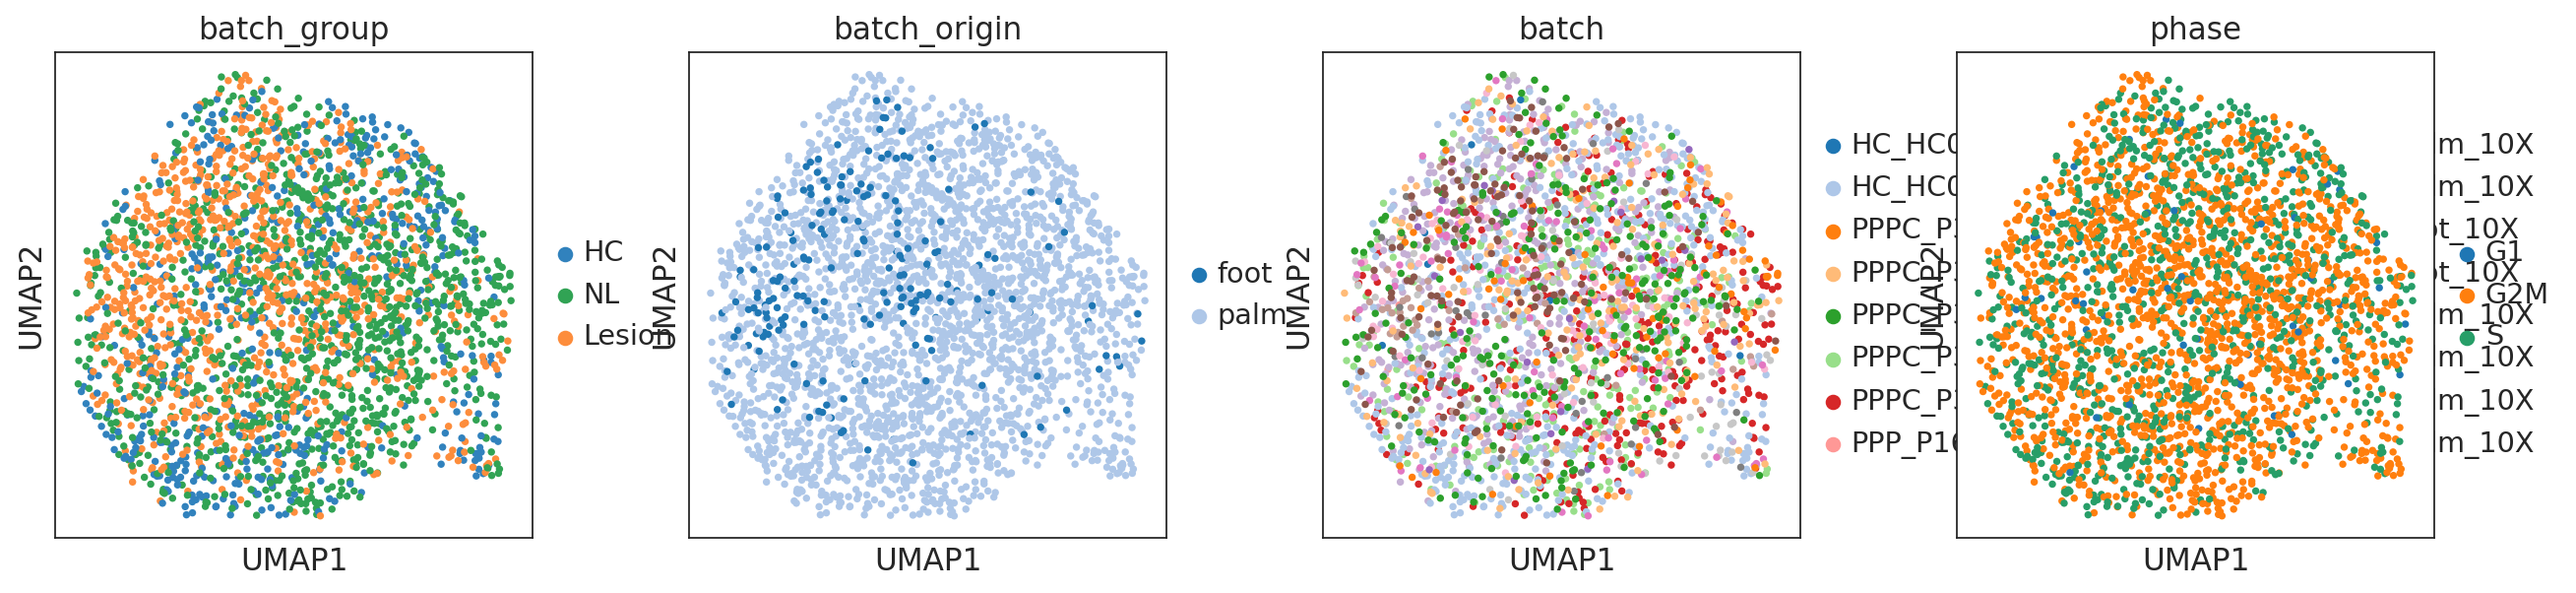

In [10]:
adata_ker_prol = adata_ker[adata_ker.obs['leiden'].isin(['Proliferating KC'])].copy()
adata_ker_prol = adata_ker_prol.raw.to_adata().copy()

sc.pp.combat(adata_ker_prol, key='batch')

sc.pp.regress_out(adata_ker_prol, ['total_counts', 'pct_counts_mt', 'S_score', 'G2M_score'], n_jobs=4, add_intercept=True)

sc.pp.highly_variable_genes(adata_ker_prol, min_mean=0.0125, max_mean=3, min_disp=0.5)
# sc.pl.highly_variable_genes(adata_ker_prol)

sc.pp.scale(adata_ker_prol, max_value=10)

sc.tl.pca(adata_ker_prol, svd_solver='arpack')
sc.pp.neighbors(adata_ker_prol, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata_ker_prol)
sc.pl.umap(adata_ker_prol, color=['batch_group', 'batch_origin', 'batch', 'phase'])

running Leiden clustering
    finished: found 7 clusters and added
    'leiden_prol', the cluster labels (adata.obs, categorical) (0:00:00)


/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


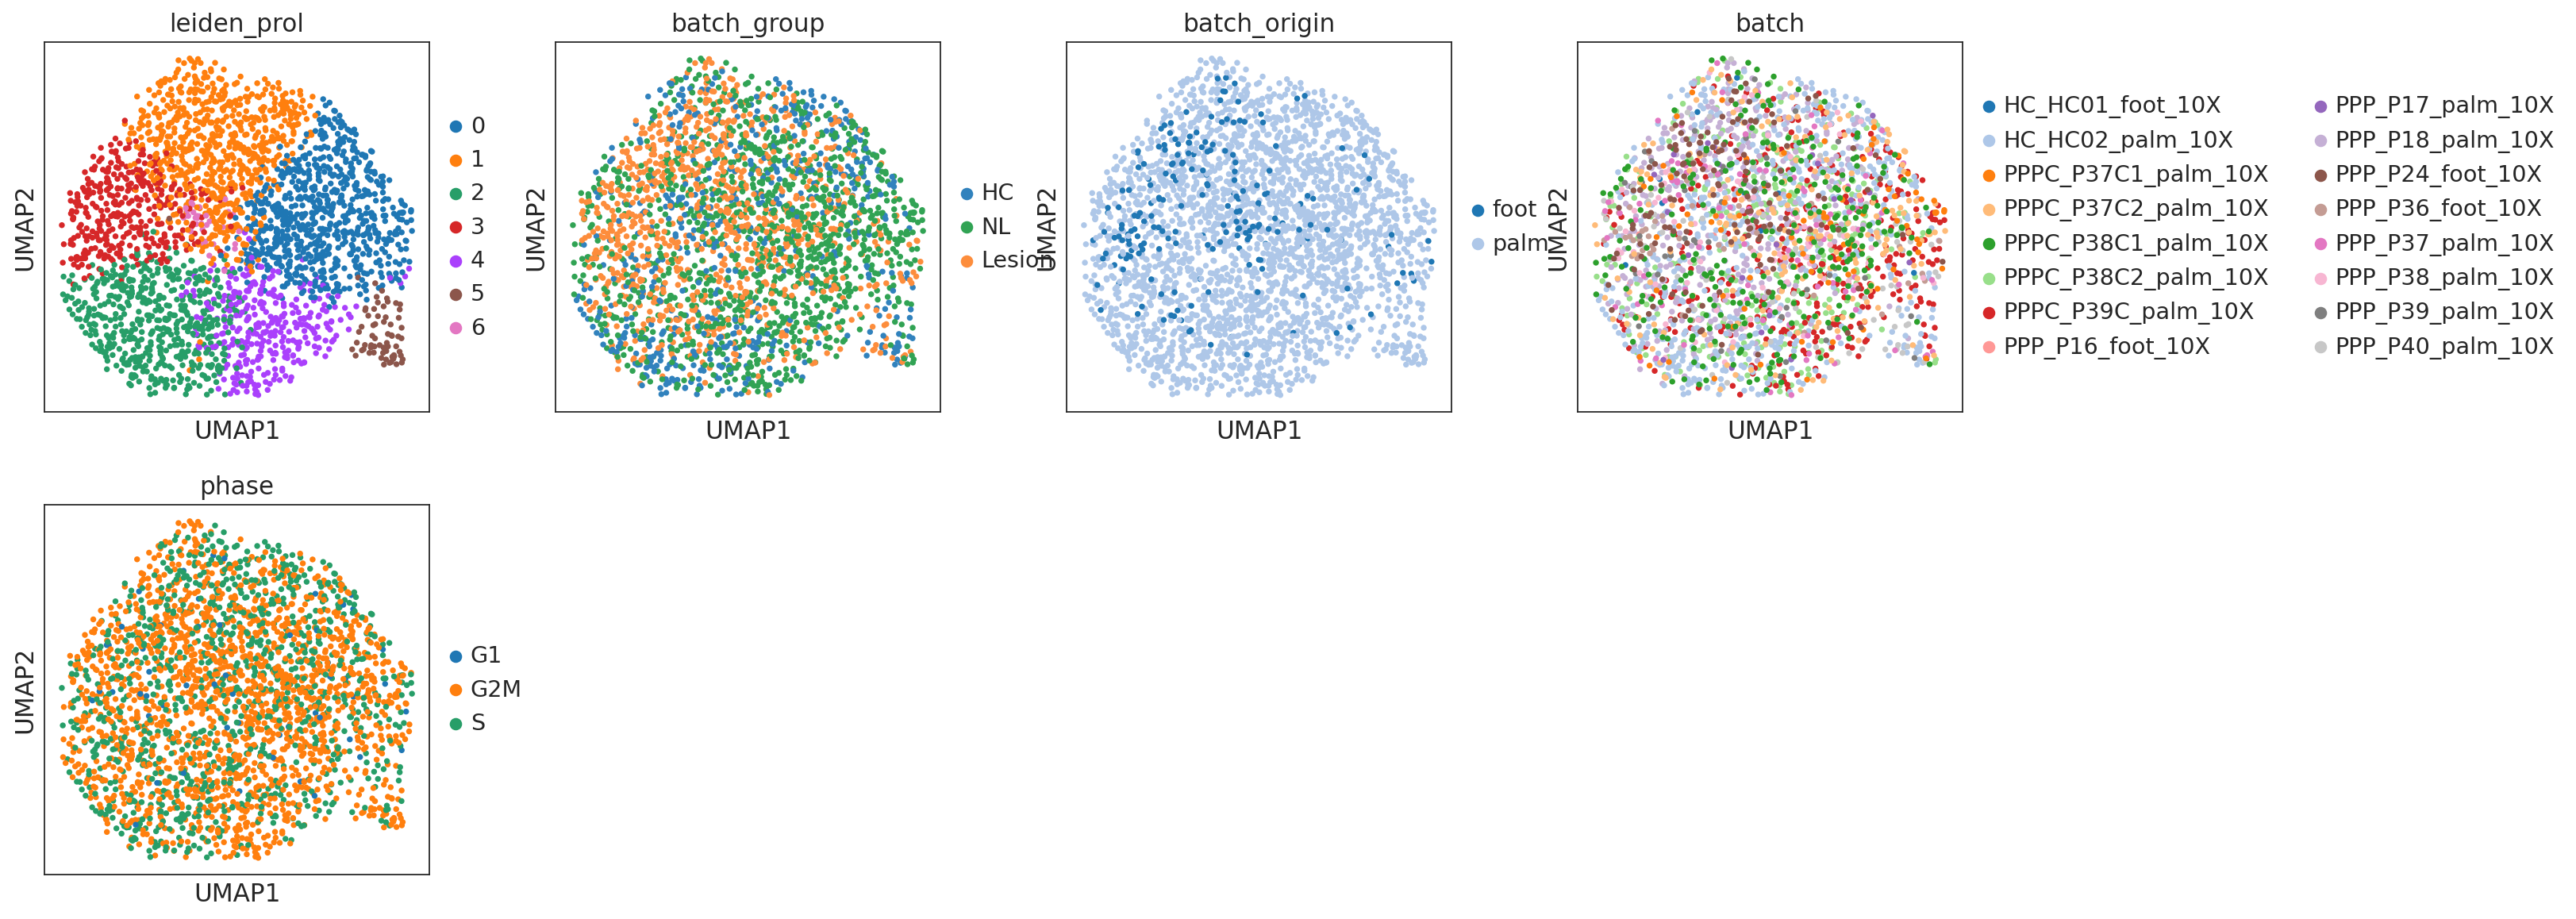

In [11]:
sc.tl.leiden(adata_ker_prol, resolution=0.6, key_added='leiden_prol')
sc.pl.umap(adata_ker_prol, color=['leiden_prol', 'batch_group', 'batch_origin', 'batch', 'phase'])

/home/wu/scanpy/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


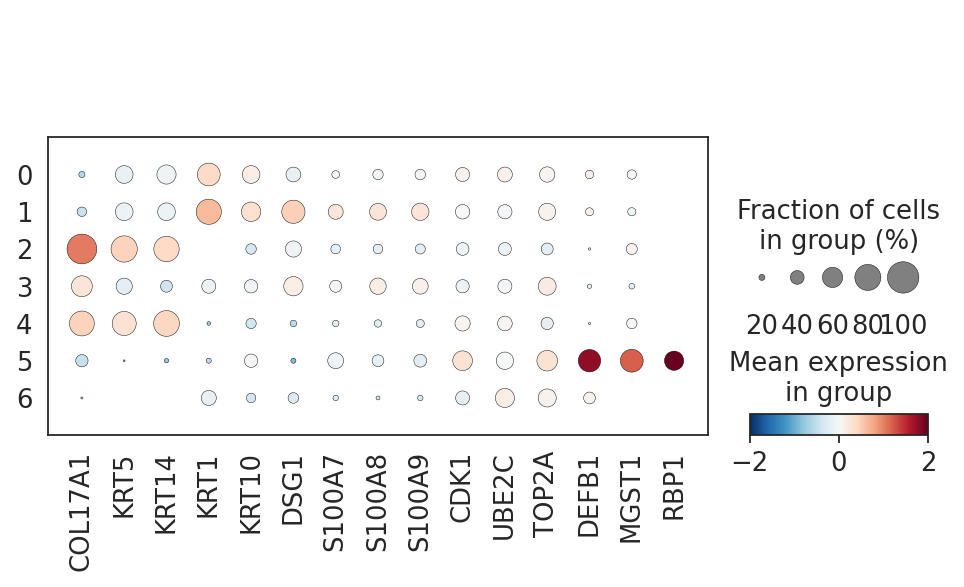

In [12]:
new_marker_genes = ['COL17A1', 'KRT5', 'KRT14', 'KRT1', 'KRT10', 'DSG1',
                    'S100A7', 'S100A8', 'S100A9', 'CDK1', 'UBE2C', 'TOP2A', 'DEFB1', 'MGST1', 'RBP1', 
                    ]

with rc_context({'figure.figsize': (8, 7)}):
    sc.pl.dotplot(adata_ker_prol, new_marker_genes, groupby='leiden_prol', show=False, use_raw=False, dot_max=1, dot_min=0.1, color_map='RdBu_r', vmax=2, vmin=-2)

/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


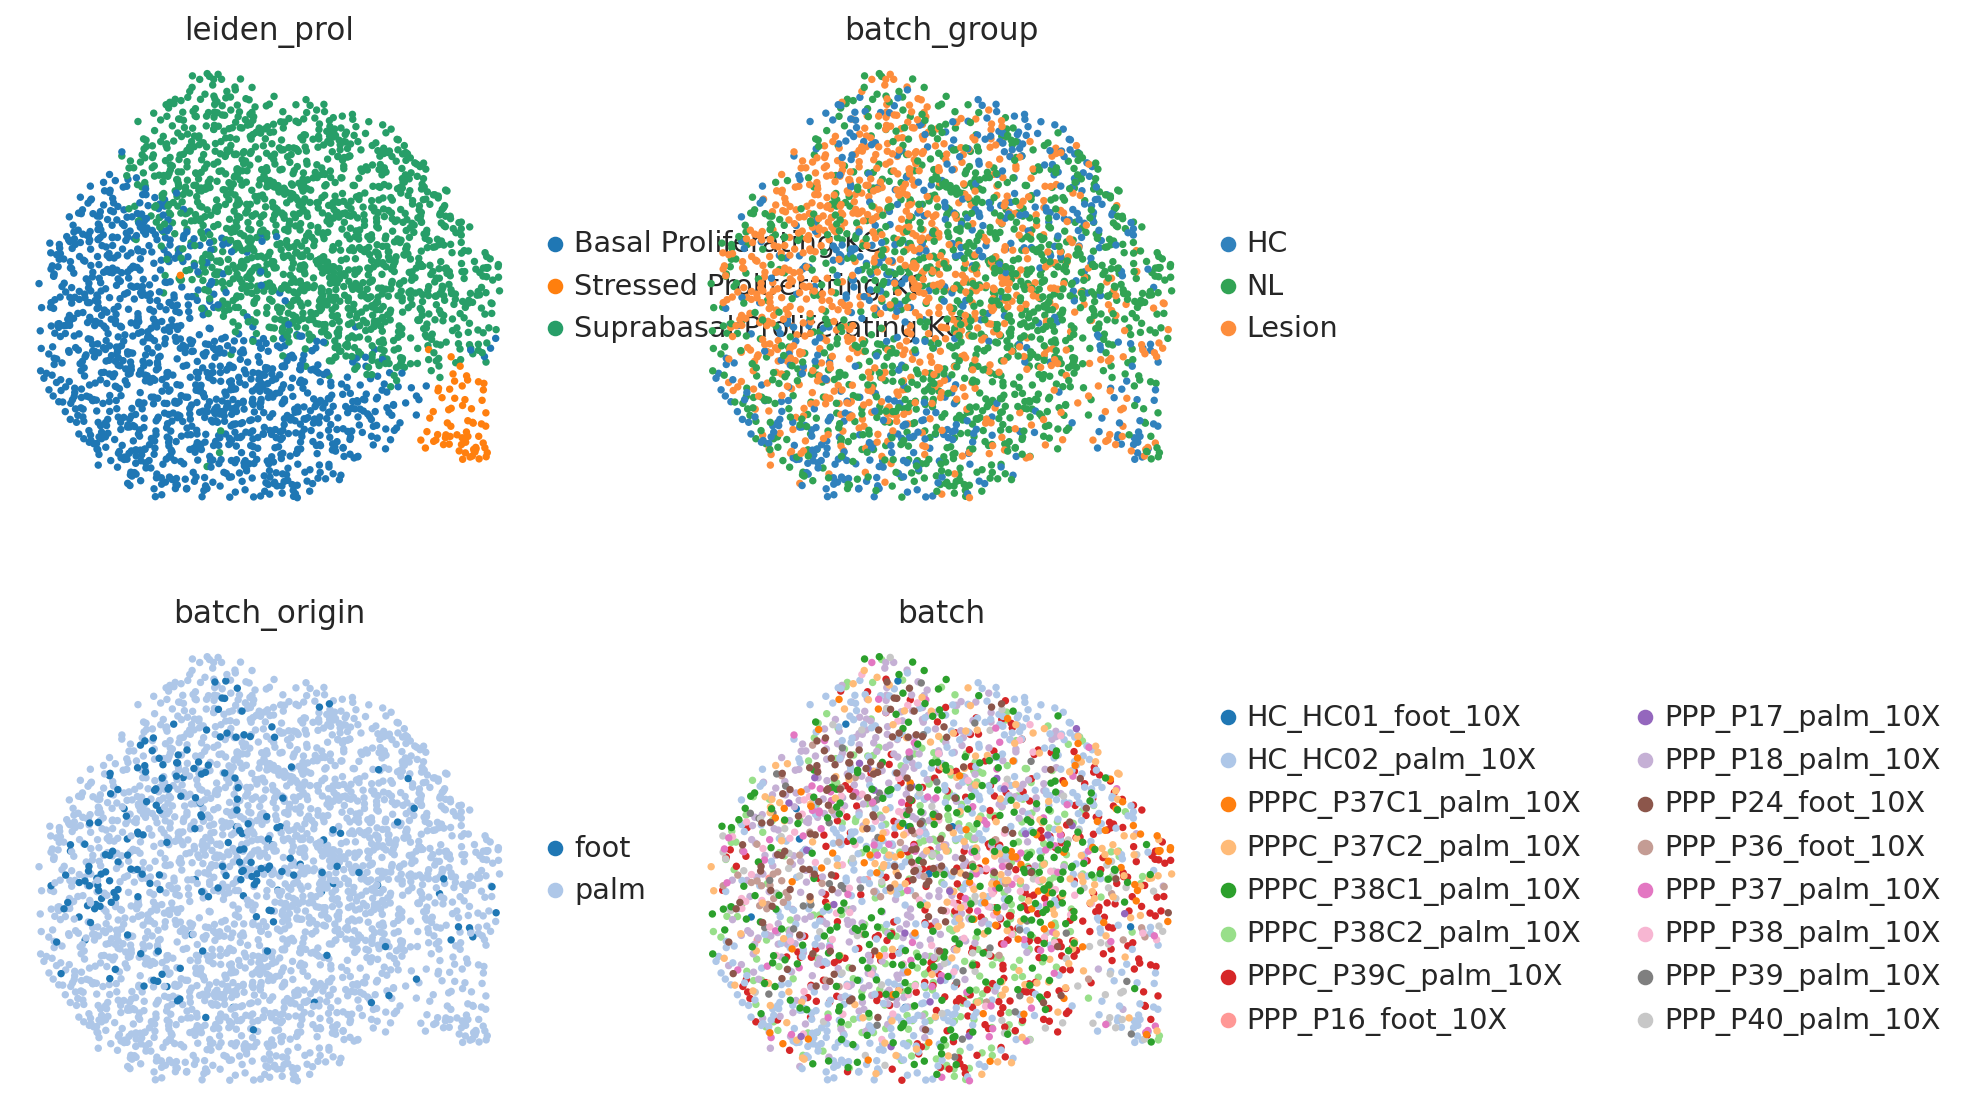

In [13]:
new_cluster_names = {
    '0': 'Suprabasal Proliferating KC',
    '1': 'Suprabasal Proliferating KC',
    '2': 'Basal Proliferating KC',
    '3': 'Basal Proliferating KC',
    '4': 'Basal Proliferating KC',
    '5': 'Stressed Proliferating KC',
    '6': 'Suprabasal Proliferating KC',
}

adata_ker_prol.obs['leiden_prol'] = adata_ker_prol.obs['leiden_prol'].map(new_cluster_names).astype('category')
sc.pl.umap(adata_ker_prol, color=['leiden_prol', 'batch_group', 'batch_origin', 'batch'], ncols=2, frameon=False)

/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


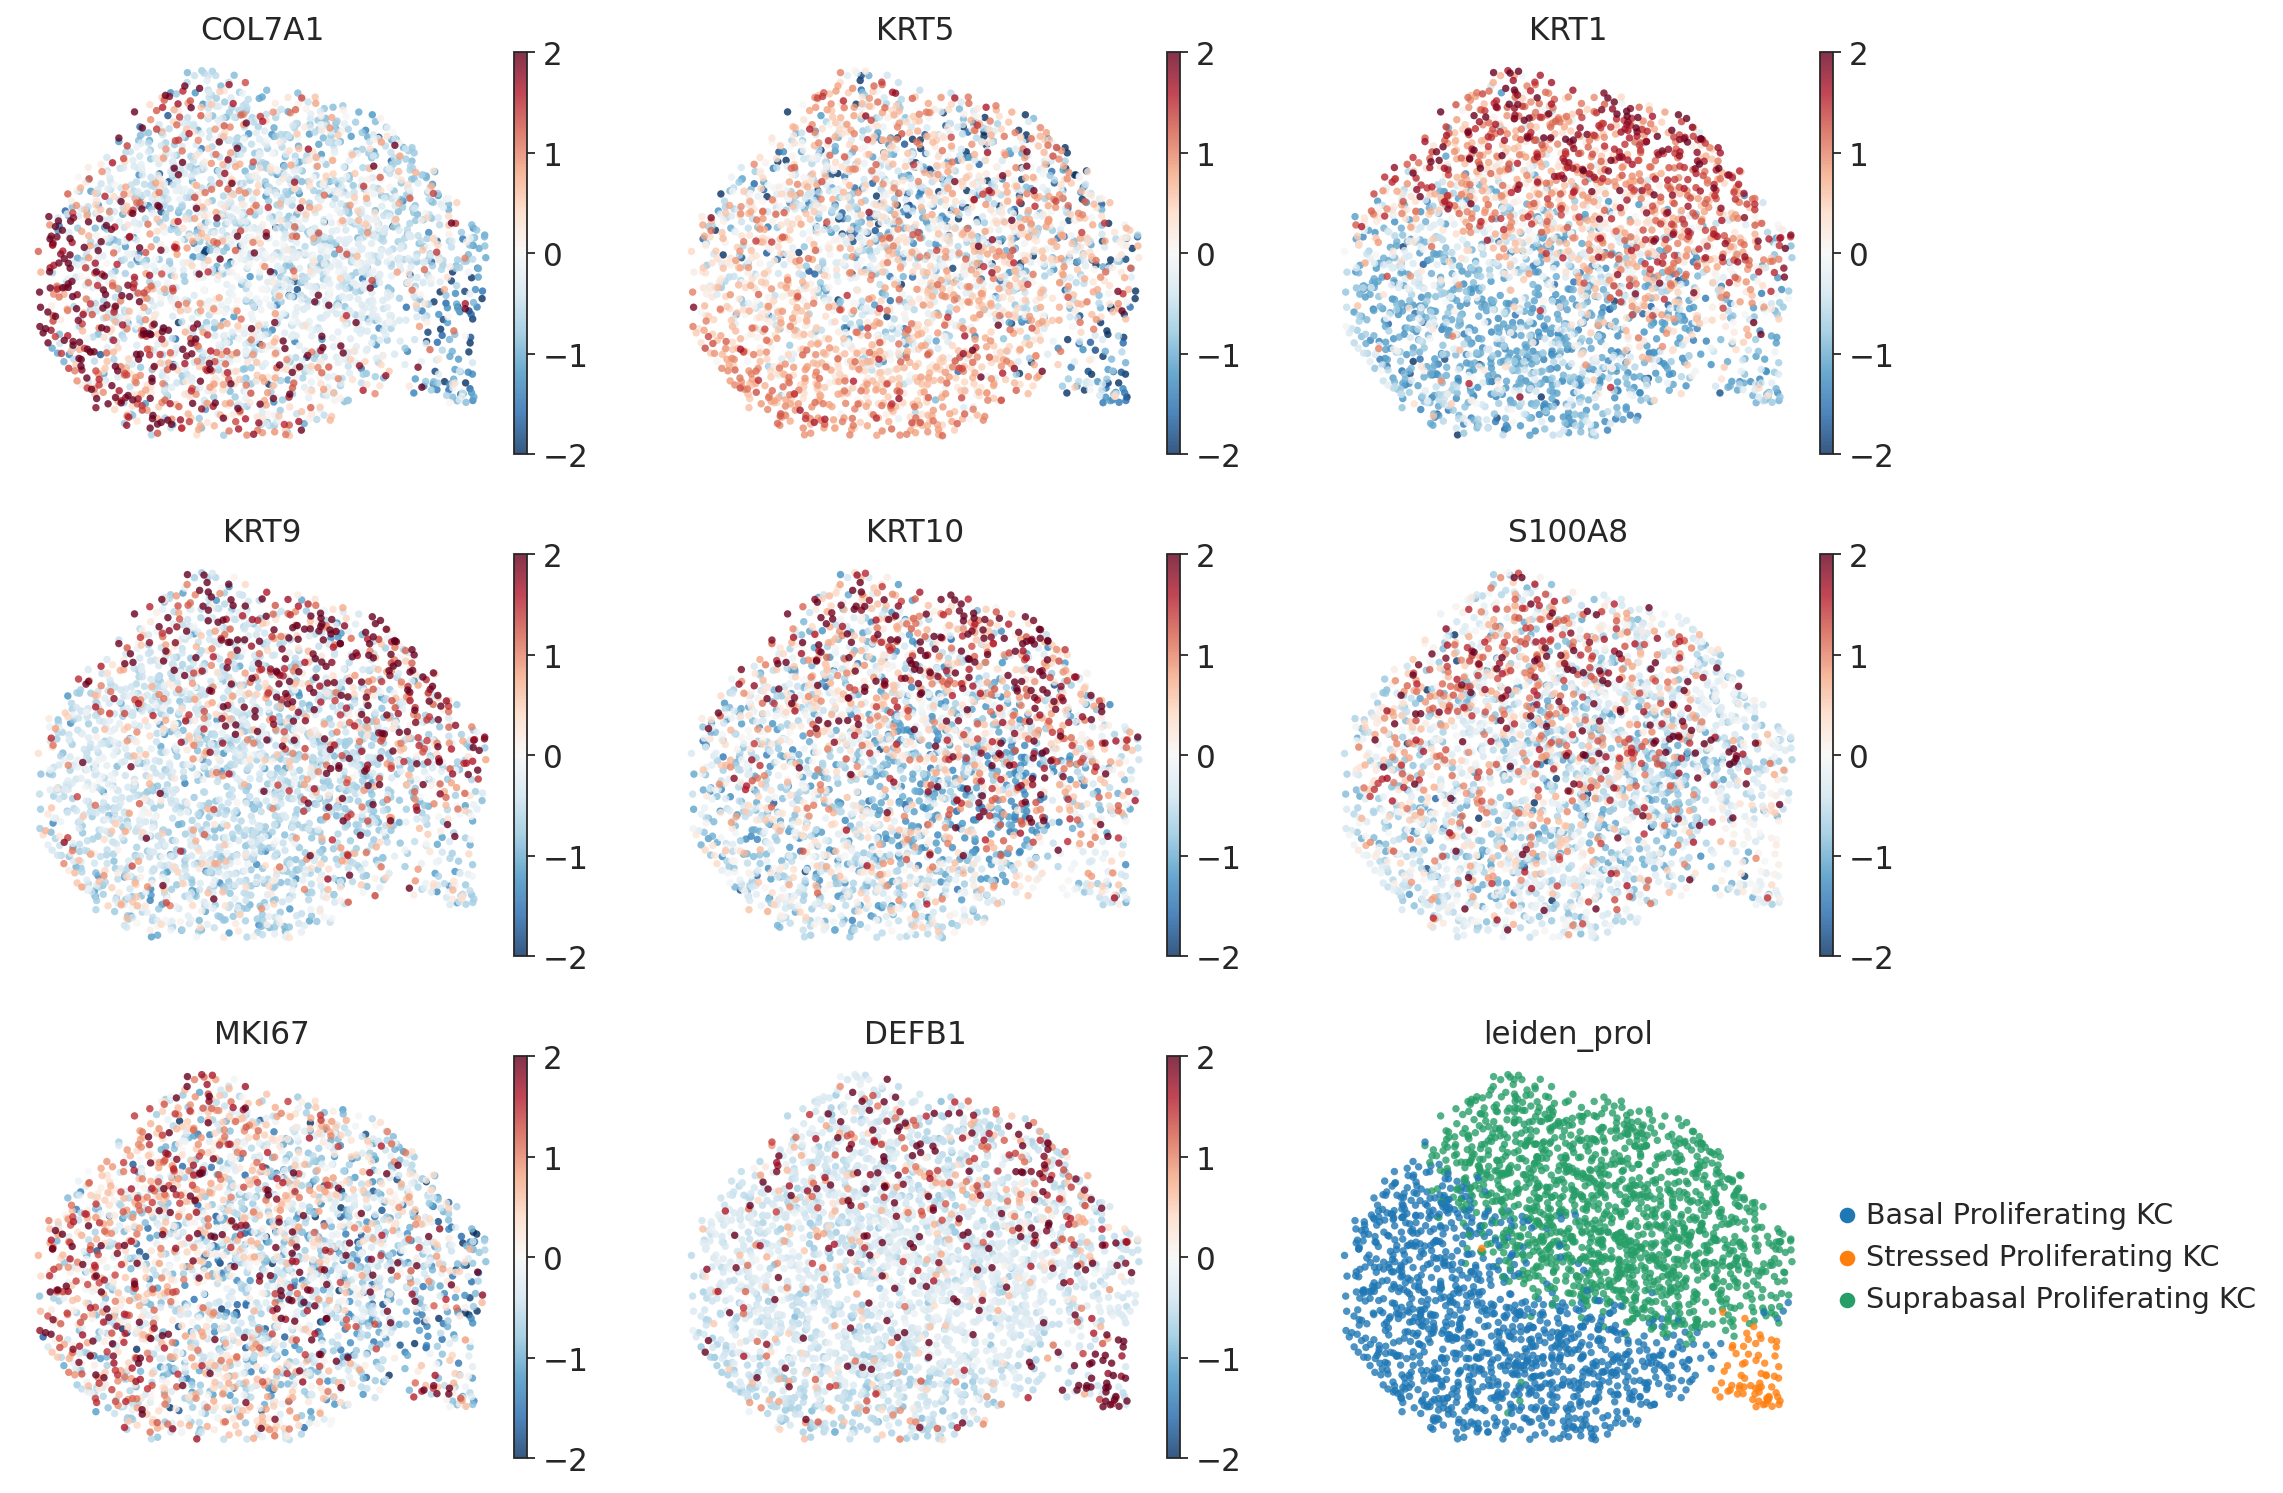

In [14]:
with rc_context({'figure.figsize': (4, 3.5)}):
    ax = sc.pl.umap(adata_ker_prol, color=['COL7A1', 'KRT5', 'KRT1', 'KRT9', 'KRT10', 'S100A8', 'MKI67', 'DEFB1', 'leiden_prol'], ncols=3, alpha=0.8, show=False, frameon=False, \
        cmap='RdBu_r', use_raw=False, vmax=2, vmin=-2)
    plt.savefig('figures/fig2_2/proliferating_kc_markers.pdf', bbox_inches='tight')

In [15]:
# reassign cell type
adata_ker.obs['cell_type'] = 'Others'
adata_ker.obs.loc[adata_ker.obs.leiden.str.contains('Basal KC'), 'cell_type'] = 'Basal'
adata_ker.obs.loc[adata_ker.obs.leiden.str.contains('Suprabasal KC'), 'cell_type'] = 'Suprabasal'
adata_ker.obs.loc[adata_ker.obs.leiden.str.contains('Stressed KC'), 'cell_type'] = 'Stressed'
adata_ker.obs.loc[adata_ker.obs.leiden.str.contains('Proliferating KC'), 'cell_type'] = adata_ker_prol.obs['leiden_prol'].copy()

In [22]:
# to wide data
df = adata_ker.obs[adata_ker.obs.cell_type.str.contains('Suprabasal')].groupby('batch').phase.value_counts() / adata_ker.obs[adata_ker.obs.cell_type.str.contains('Suprabasal')].groupby('batch').phase.count()
df = pd.DataFrame(df)
df.columns = ['fraction']
df = df.pivot_table(index='batch', columns='phase', values='fraction')
df['Meta'] = 'Lesion'
df.loc[df.index.str.contains('C'), 'Meta'] = 'Control'
df = df.reset_index()
df['S/G2M'] = df['S'] + df['G2M']

Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:2.290e-02 U_stat=5.300e+01
Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:2.290e-02 U_stat=1.000e+01


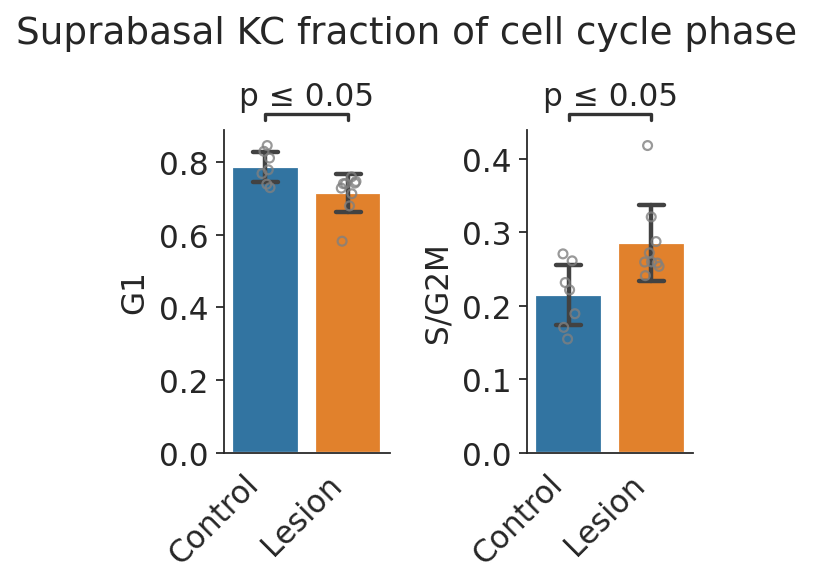

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(4, 3.5))
order = ['Control', 'Lesion']
pairs = [('Control', 'Lesion')]

for i, phase in enumerate(['G1', 'S/G2M']):
    sns.barplot(x='Meta', y=phase, data=df, ax=ax[i], order=order, ci="sd", 
                capsize=0.3, errwidth=2, dodge=True)
    sns.stripplot(x=df['Meta'], y=df[phase], ax=ax[i], size=5, alpha=0.8, color='gray', marker="$\circ$")
    ax[i].set_xlabel('')
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, horizontalalignment='right')
    ax[i].yaxis.set_ticks_position('left')
    annotator = Annotator(ax[i], pairs=pairs, data=df, x='Meta', y=phase, order=order)
    annotator.configure(test="Mann-Whitney", text_format='simple', loc='outside', show_test_name=False)
    annotator.apply_and_annotate()
sns.despine()
fig.tight_layout()
fig.suptitle('Suprabasal KC fraction of cell cycle phase', y=1.05)
plt.savefig('figures/fig2_2/suprabasal_kc_cell_cycle_phase.pdf', bbox_inches='tight')

In [24]:
# to wide data
df = adata_ker.obs[adata_ker.obs.cell_type.str.contains('Basal')].groupby('batch').phase.value_counts() / adata_ker.obs[adata_ker.obs.cell_type.str.contains('Suprabasal')].groupby('batch').phase.count()
df = pd.DataFrame(df)
df.columns = ['fraction']
df = df.pivot_table(index='batch', columns='phase', values='fraction')
df['Meta'] = 'Lesion'
df.loc[df.index.str.contains('C'), 'Meta'] = 'Control'
df = df.reset_index()
df['S/G2M'] = df['S'] + df['G2M']

Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:1.738e-01 U_stat=4.500e+01
Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:5.360e-01 U_stat=2.500e+01


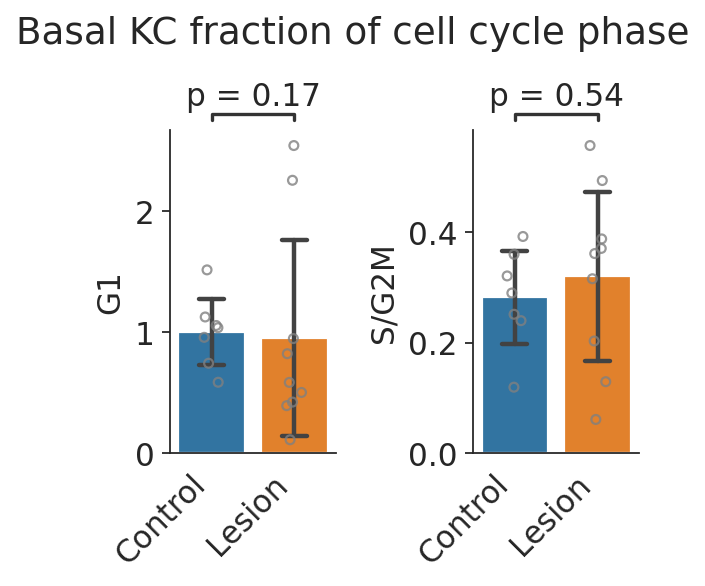

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(4, 3.5))
order = ['Control', 'Lesion']
pairs = [('Control', 'Lesion')]

for i, phase in enumerate(['G1', 'S/G2M']):
    sns.barplot(x='Meta', y=phase, data=df, ax=ax[i], order=order, ci="sd", 
                capsize=0.3, errwidth=2, dodge=True)
    sns.stripplot(x=df['Meta'], y=df[phase], ax=ax[i], size=5, alpha=0.8, color='gray', marker="$\circ$")
    ax[i].set_xlabel('')
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, horizontalalignment='right')
    ax[i].yaxis.set_ticks_position('left')
    annotator = Annotator(ax[i], pairs=pairs, data=df, x='Meta', y=phase, order=order)
    annotator.configure(test="Mann-Whitney", text_format='simple', loc='outside', show_test_name=False)
    annotator.apply_and_annotate()
sns.despine()
fig.tight_layout()
fig.suptitle('Basal KC fraction of cell cycle phase', y=1.05)
plt.savefig('figures/fig2_2/basal_kc_cell_cycle_phase.pdf', bbox_inches='tight')